## overview
- training a model using masking to predict missing values in order to evaluate patient's overall performance
- visualization for how a patient's ground truth and prediction scores compare
- comparison with baseline (using average imputation methods)

In [1440]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from sklearn.model_selection import train_test_split
import random

Initialize run

wandb initialization

In [1441]:
# run = wandb.init(project='prediction model for CT-masking')

In [1442]:
## set seed for pytorch model and scikit learn and numpy but not overall because patient needs to be chosen randomly
# torch.manual_seed(42)
# np.random.seed(42)

Data

In [1443]:
df = pd.read_csv("data/filtered_ds.csv")

In [1444]:
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [1445]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [1446]:
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1,14))
    scores = np.zeros((len(data), 14))
    i = 0
    
    data = data.sort_values(by=["start_time_min"])
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [1447]:
data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_85808/1806359856.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)


In [1448]:
model_data = data[["patient_id"] + ["domain %d score" % i for i in range(1, 15)]]

In [1449]:
model_data

,patient_id,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,14696,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,14696,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,14696,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,14696,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,14696,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,408963,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,408963,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,408963,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,408963,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [1450]:
def filter_rows_by_list(data, column_name, value_list):
    """
    Filters rows in the DataFrame where the specified column's values are in the provided list.

    Parameters:
    - data (pd.DataFrame): The DataFrame to filter.
    - column_name (str): The name of the column to filter by.
    - value_list (list): A list of values to include in the filter.

    Returns:
    - pd.DataFrame: A DataFrame containing only rows where the column values are in the value_list.
    """
    # Use the isin() method to find rows where the column value is in the list
    filtered_data = data[data[column_name].isin(value_list)]

    return filtered_data

In [1451]:
# ## pick a random patient for case study
# pid = random.choice(pd.unique(model_data["patient_id"]))
# ## save the patient's data
# case_study_data = copy.deepcopy(model_data[model_data['patient_id'] == pid])
# ## remove the patient's data from the dataset
# model_data = model_data.drop(model_data[model_data['patient_id'] == pid].index)

# ## reset index for the case study
# case_study_data = case_study_data.reset_index(drop=True)

In [1452]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [1453]:
model_data = filter_nonzero_rows(model_data, 0)

In [1454]:
patient_train, patient_test = train_test_split(model_data["patient_id"].unique(), test_size=0.1)

In [1455]:
train_data = filter_rows_by_list(model_data, "patient_id", patient_train)
test_data = filter_rows_by_list(model_data, "patient_id", patient_test)

In [1456]:
train_data = train_data[["domain %d score" % i for i in range(1, 15)]]

In [1457]:
train_data = train_data.to_numpy()

In [1458]:
def generate_random_array(rows, cols, ratio_of_zeros):
    total_elements = rows * cols
    num_zeros = int(total_elements * ratio_of_zeros)
        
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign zeros to the array
    indices = np.random.choice(total_elements, num_zeros, replace=False)
    array.ravel()[indices] = 0
    
    return array

In [1459]:
def generate_mask(data, ratio=0.8):
    rows, cols = data.shape
    assert(cols == 14)
    domains_masked = generate_random_array(rows, cols, ratio)
    return data * domains_masked

In [1460]:
ground_truth = copy.deepcopy(train_data)
train_data = generate_mask(train_data, ratio=0.9)

In [1461]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("shouldn't be here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [1462]:
train_data = create_missing_indicator(train_data)
ground_truth = create_missing_indicator(ground_truth)

Model

In [1463]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        hidden1 = 100
        hidden2 = 25
        
        self.encoder = torch.nn.Sequential(
            # torch.nn.Dropout(0.8),
            torch.nn.Linear(n_domains * 2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.Sigmoid()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, n_domains * 2)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

masking

In [1464]:
def missing(arr):
    return arr[0] == arr[1]

Training

In [1465]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for i in range(len(x_train)):
            session = x_train[i]
            # Output of Autoencoder
            session_rs = session.reshape(-1, w * 2)
            session_t = torch.from_numpy(session_rs).float()
            reconstructed = model(session_t)
            
            # # handle missing value
            missing_exists = False
            missing_domains = []
            for domain in range(w):
                if missing(session[domain*2:domain*2+2]):
                    missing_exists = True
                    missing_domains.append(domain)
                
            if missing_exists:
                session_dc = copy.deepcopy(y_train[i])
                target = reconstructed.detach().numpy()[0]
                for d in missing_domains:
                    # print(session_dc.shape, d, target)
                    session_dc[d*2:d*2+2] = target[d*2:d*2+2]
                session_dc = session_dc.reshape(-1, w * 2)
                session_t = torch.from_numpy(session_dc).float()


            # Calculating the loss function
            loss = loss_function(reconstructed, session_t)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        outputs.append((epochs, session_t, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            for k in range(len(x_val)):
                val = x_val[k]
                val_rs = val.reshape(-1, w * 2)
                val_t = torch.from_numpy(val_rs)
                val_t = val_t.clone().detach().type(torch.float32)
                answer = model(val_t)
                val_loss = loss_function(answer, torch.tensor(y_val[k]).type(torch.float32))
                val_epoch_loss.append(val_loss.item())
        val_losses.append(statistics.mean(val_epoch_loss))
    print(val_losses)
    return losses, val_losses, outputs, model

In [1466]:
num_runs = 1

In [1467]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = AE()
    epochs = 5
    lr = 0.005

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(train_data, ground_truth, test_size=0.50)
    with torch.no_grad():
        predictions = model(torch.from_numpy(x_train).float())
        zero_loss = loss_function(predictions, torch.from_numpy(y_train).float())

        predictions = model(torch.from_numpy(x_val).float())
        zero_loss_val = loss_function(predictions, torch.from_numpy(y_val).float())
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

/opt/homebrew/anaconda3/envs/ct/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([1, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0.07008586777234826, 0.07129734326182346, 0.0736388196835329, 0.07615514444726973, 0.07597911406367759]


In [1468]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='Mean', color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='Standard Deviation')
    
    plt.title('Mean and Standard Deviation Plot of %s' %setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

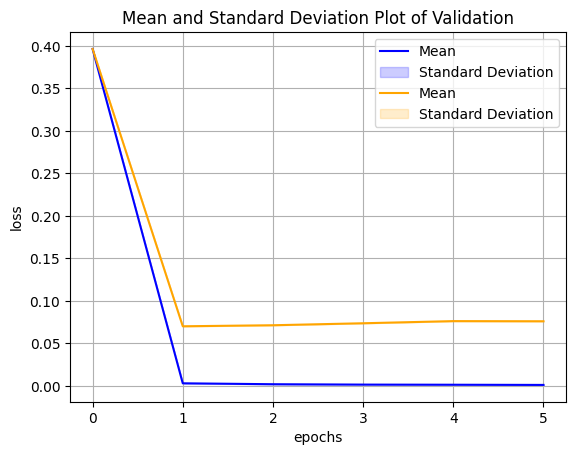

In [1469]:
# Defining the Plot Style

# Plotting
with torch.no_grad():
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

# wandb.log(
#     {
#         "train val loss": wandb.plot.line_series(
#             xs=range(1, epochs + 1),
#             ys=[losses, val_losses],
#             keys=["Train", "Validation"],
#             title="training and validation loss",
#             xname="epochs",
#         )
#     }
# )

In [1470]:
def enhanced_box_plot(data_array):
    """
    Creates a box plot for each column in the given NumPy array and overlays mean and standard deviation.
    
    Parameters:
    - data_array (numpy.ndarray): A 2D NumPy array where each column represents a series of data points.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    # Create the boxplot
    bp = ax.boxplot(data_array, patch_artist=True, notch=True, meanline=True)
    
    # Calculate means and standard deviations
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    n_cols = data_array.shape[1]

    # Add mean and standard deviation lines
    for i in range(n_cols):
        # Mean line
        plt.plot([i+1], [means[i]], color='red', marker='o', markersize=5)
        # Standard deviation lines
        plt.plot([i+1, i+1], [means[i] - stds[i], means[i] + stds[i]], color='purple', marker='_', markersize=10, linestyle='None')

    # Customizing the plot
    plt.title('Box Plot with Mean and Standard Deviation')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# enhanced_box_plot(train_data[:, 0::2])

In [1471]:
np.mean(x_train, axis=0)

array([0.50589964, 0.49417035, 0.50548577, 0.49974581, 0.53446286,
       0.46390993, 0.49858415, 0.50411037, 0.48090085, 0.52142624,
       0.51374974, 0.48462305, 0.50984883, 0.49156842, 0.52575196,
       0.47498291, 0.49130569, 0.51077644, 0.50666077, 0.48926245,
       0.53572201, 0.4692821 , 0.49360791, 0.50670703, 0.51285091,
       0.49070096, 0.52644251, 0.47829914])

Error Plots

In [1472]:
def impute_with_column_mean(data):
    """
    Imputes missing values (represented as 0) in a DataFrame with the mean of the non-zero values in the same column.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed using column means.
    """
    # Replace '0' with NaN to handle them as missing values
    imputed_data = data.replace(0, np.nan)
    
    # Calculate the mean of each column, ignoring NaNs
    column_means = imputed_data.mean()
    
    # Replace NaN values in each column with the mean of that column
    imputed_data.fillna(column_means, inplace=True)

    return imputed_data

In [1473]:
def impute_with_row_average(data):
    """
    Imputes missing values (NaN) in a DataFrame with the average of the non-missing values in the same row.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    imputed_data = data.copy()
    # Replace '0' with NaN to handle them as missing values
    imputed_data = data.replace(0, np.nan)

    # Iterate over each row
    for index, row in imputed_data.iterrows():
        # Calculate the mean of the non-NaN values in the row
        mean_value = row[row.index.difference(["patient_id"])].mean()

        # Replace NaN values in the row with the calculated mean
        imputed_data.loc[index] = row.fillna(mean_value)

    return imputed_data

In [1474]:
# mode = other => impute by average of other domains, mode = data => impute by average of the data set
def imputation(data, mode=""):
    if mode == "other":
        return impute_with_row_average(data)
    elif mode == "data":
        return impute_with_column_mean(data)

In [1475]:
# get predictions from the model
def predict(data, model):
    model.eval()
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        return model(data).numpy()

In [1476]:
test_data

,patient_id,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
56998,29278,0.357,0.48,0.840,0.757,0.52,0.642,0.51,1.0,0.280,0.536,0.80,0.536,0.667,1.000
56999,29278,0.357,0.48,0.840,0.757,0.52,0.642,0.51,1.0,0.280,0.536,0.80,0.536,0.667,1.000
57000,29278,0.357,0.48,0.840,0.757,0.52,0.642,0.51,1.0,0.280,0.536,0.80,0.536,0.667,1.000
57001,29278,0.357,0.48,0.840,0.757,0.52,0.642,0.51,1.0,0.280,0.536,0.80,0.536,0.557,1.000
57002,29278,0.357,0.48,0.840,0.757,0.52,0.642,0.51,1.0,0.280,0.536,0.80,0.536,0.557,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712797,225159,0.314,0.02,0.896,0.438,0.22,0.040,0.52,1.0,0.067,0.469,0.68,0.364,0.735,0.427
1712798,225159,0.314,0.02,0.896,0.438,0.22,0.040,0.52,1.0,0.067,0.469,0.68,0.364,0.735,0.427
1712799,225159,0.314,0.02,0.896,0.438,0.22,0.040,0.52,1.0,0.067,0.469,0.68,0.364,0.735,0.427
1712800,225159,0.314,0.03,0.896,0.438,0.22,0.040,0.52,1.0,0.067,0.469,0.68,0.364,0.735,0.427


In [1477]:
column_names = ["domain %d score" % i for i in range(1, 15)]

In [1478]:
index_list = test_data.index.tolist()
## create masked testing data so we can see how the model predicts and how imputation compares
masked_test_data = generate_mask(test_data[column_names].copy().to_numpy(), ratio=0.2)
predictions = predict(torch.from_numpy(create_missing_indicator(masked_test_data)).float(), model)
predictions_indexed = dict(zip(index_list, predictions))

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_85808/3625449898.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_t = torch.tensor(data, dtype=torch.float32)


In [1479]:
imputation_other = imputation(pd.DataFrame(masked_test_data, columns=column_names), mode="other")
imputataion_data = imputation(pd.DataFrame(masked_test_data, columns=column_names), mode="data")
imputation_other["patient_id"] = test_data["patient_id"].reset_index(drop=True)
imputataion_data["patient_id"] = test_data["patient_id"].reset_index(drop=True)

In [1480]:
imputataion_data

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score,patient_id
0,0.357,0.480000,0.840,0.757,0.520000,0.642000,0.510000,1.000000,0.280000,0.53600,0.885592,0.536000,0.655524,1.000000,29278
1,0.357,0.494911,0.840,0.757,0.520000,0.586884,0.510000,1.000000,0.280000,0.53600,0.800000,0.536000,0.667000,1.000000,29278
2,0.357,0.480000,0.840,0.757,0.286341,0.586884,0.513437,1.000000,0.280000,0.49509,0.800000,0.536000,0.667000,0.821455,29278
3,0.357,0.480000,0.840,0.757,0.520000,0.586884,0.510000,1.000000,0.280000,0.53600,0.800000,0.421722,0.557000,1.000000,29278
4,0.357,0.480000,0.840,0.757,0.520000,0.642000,0.510000,1.000000,0.280000,0.53600,0.800000,0.536000,0.557000,0.821455,29278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21819,0.314,0.020000,0.896,0.438,0.220000,0.040000,0.520000,1.000000,0.067000,0.46900,0.680000,0.364000,0.655524,0.427000,225159
21820,0.314,0.020000,0.896,0.438,0.220000,0.040000,0.520000,1.000000,0.352811,0.49509,0.680000,0.364000,0.655524,0.427000,225159
21821,0.314,0.020000,0.896,0.438,0.286341,0.040000,0.513437,0.680161,0.067000,0.49509,0.885592,0.364000,0.735000,0.427000,225159
21822,0.314,0.030000,0.896,0.438,0.220000,0.040000,0.520000,0.680161,0.352811,0.46900,0.680000,0.364000,0.735000,0.427000,225159


Visualization

In [1481]:
pd.unique(test_data["patient_id"])

array([ 29278,  34388, 131626, 132882, 136323, 136597, 139774, 151604,
       158368, 159540, 160023, 165439, 168858, 170763, 171463, 173109,
       173976, 174411, 174605, 174695, 182776, 201668, 225159])

In [1482]:
## individual first
pid = random.choice(pd.unique(test_data["patient_id"]))
# pid = 
GT = test_data[test_data["patient_id"] ==  pid][column_names]
patient_impute_other = imputation_other[imputation_other["patient_id"] == pid][column_names]
patient_impute_data = imputataion_data[imputataion_data["patient_id"] == pid][column_names]
GT_indices = GT.index.tolist()
patient_predictions = pd.DataFrame(np.vstack([predictions_indexed[idx] for idx in GT_indices])[:, ::2], columns=column_names)

In [1483]:
# using average scores
GT_mean = GT.mean(axis=1)
patient_impute_other_mean = patient_impute_other.mean(axis=1)
patient_impute_data_mean = patient_impute_data.mean(axis=1)
patient_predictions_mean = patient_predictions.mean(axis=1)

In [1484]:
MSE_prediction = np.square(np.subtract(GT_mean.reset_index(drop=True), patient_predictions_mean.reset_index(drop=True)))
MSE_other = np.square(np.subtract(GT_mean.reset_index(drop=True), patient_impute_other_mean.reset_index(drop=True)))
MSE_data = np.square(np.subtract(GT_mean.reset_index(drop=True), patient_impute_data_mean.reset_index(drop=True)))

In [1485]:
MSE_prediction.mean(), MSE_data.mean()

(0.004152966898326822, 0.001336964952770391)

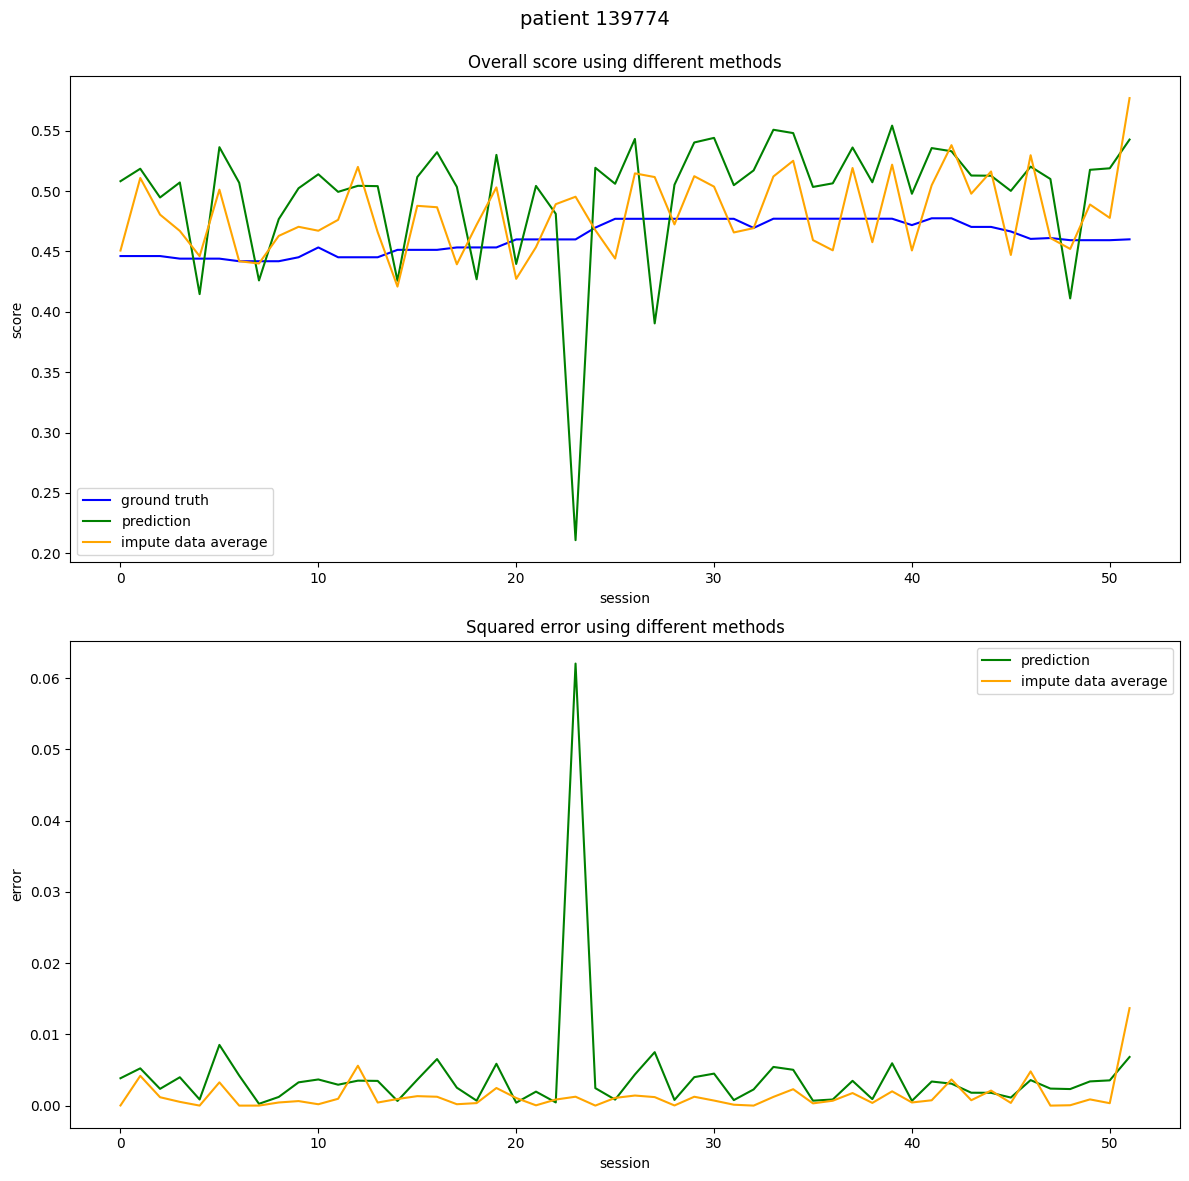

In [1486]:
fig = plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
x = range(len(GT_mean))
plt.plot(x, GT_mean, "blue", x, patient_predictions_mean, "green", x, patient_impute_data_mean, "orange")
plt.legend(["ground truth", "prediction", "impute data average"])
plt.title("Overall score using different methods")
plt.ylabel("score")
plt.xlabel("session")

plt.subplot(2, 1, 2)
x = range(len(GT_mean))
plt.plot(x, MSE_prediction, "green", x, MSE_data, "orange")
plt.legend([ "prediction", "impute data average"])
plt.title("Squared error using different methods")
plt.ylabel("error")
plt.xlabel("session")

fig.suptitle("patient %d" % pid, size=14)
fig.tight_layout()
fig.subplots_adjust(top=0.925)

### See how this changes the score trajectory

In [1487]:
# data

In [1488]:
# column_names = ["domain %d score" % i for i in range(1, 15)]
# column_rename_dict = {}
# for i in range(len(column_names)):
#     column_rename_dict[column_names[i]] = i + 1

In [1489]:
def get_score(data : pd.DataFrame):
    updated_domain_pct = dict() # keeps updated domain pct
    score = 0 # score for each session, an average of all available domains
    scores = []

    data = data.sort_values(by="start_time_min").reset_index(drop=True)
    column_names = ["domain %d score" % i for i in range(1, 15)]

    for idx, row in data.iterrows():
        domain_ids, _ = process_row(row)
        for j in range(len(domain_ids)):
            col = column_names[int(domain_ids[j] - 1)]
            updated_domain_pct[col] = row[col] # update domain pct to the latest one
        # find sum of all domain pct
        for k, v in updated_domain_pct.items():
            score += float(v)
        # take average of domain pct, add to list, reset score to 0
        score /= len(updated_domain_pct)
        scores.append(score)
        score = 0
    # return scores list
    return scores

In [1490]:
# no_pred_scores = get_score(data[data.patient_id == pid])

In [1491]:
# patient_data_scores = case_study_data[column_names].to_numpy()
# patient_data_scores.shape

In [1492]:
# l, w = patient_data_scores.shape

In [1493]:
# temp = np.zeros((l, w*2))
# for i in range(l):
#     for d in range(w):
#         p = patient_data_scores[i, d]
#         # update output array
#         if p == 0:
#             # print("shouldn't be here")
#             missing_ind = np.random.choice(2, 1)[0]
#             temp[i, d*2] = missing_ind
#             temp[i, d*2+1] = missing_ind
#         else:
#             temp[i, d*2] = p # score
#             temp[i, d*2+1] = 1-p # 1-score

# patient_data_scores = copy.deepcopy(temp)

In [1494]:
# input_tensor = torch.tensor(patient_data_scores, dtype=torch.float32)

# predictions = []

# for row in input_tensor:
#     # Reshape row to (1, 28) if necessary
#     row = row.unsqueeze(0) if len(row.shape) == 1 else row
#     # Forward pass through the model
#     with torch.no_grad():
#         # print(model(row))
#         output = model(row)
        
#     # Append predictions to the list
#     predictions.append(output.numpy())

# predictions = np.array(predictions)

In [1495]:
# predictions = predictions.reshape(l, w * 2)
# predictions = predictions[:, ::2]

In [1496]:
def remove_zero_columns(df1, df2):
    """
    Removes columns from the second DataFrame that correspond to all-zero columns in the first DataFrame.

    Parameters:
    - df1 (pd.DataFrame): A DataFrame where some columns might have all elements as zero.
    - df2 (pd.DataFrame): A DataFrame from which the corresponding all-zero columns in df1 will be removed.

    Returns:
    - pd.DataFrame: A modified DataFrame with the all-zero columns removed from df2.
    """
    # Check that the number of columns in df1 and df2 match
    if df1.shape[1] != df2.shape[1]:
        raise ValueError("Both DataFrames must have the same number of columns.")

    # Find columns in the first DataFrame that have all zeros
    zero_columns = df1.columns[(df1 == 0).all()]

    # Remove the corresponding columns from the second DataFrame
    filtered_df = df2.drop(columns=zero_columns)

    return filtered_df

In [1497]:
# Calculate the difference
difference = patient_predictions - GT.iloc[:, -14:].to_numpy()
difference = pd.DataFrame(data=difference, columns=column_names)
difference = remove_zero_columns(GT.iloc[:, -14:], difference)

In [1498]:
# predictions = pd.DataFrame(data=predictions, columns=column_names)

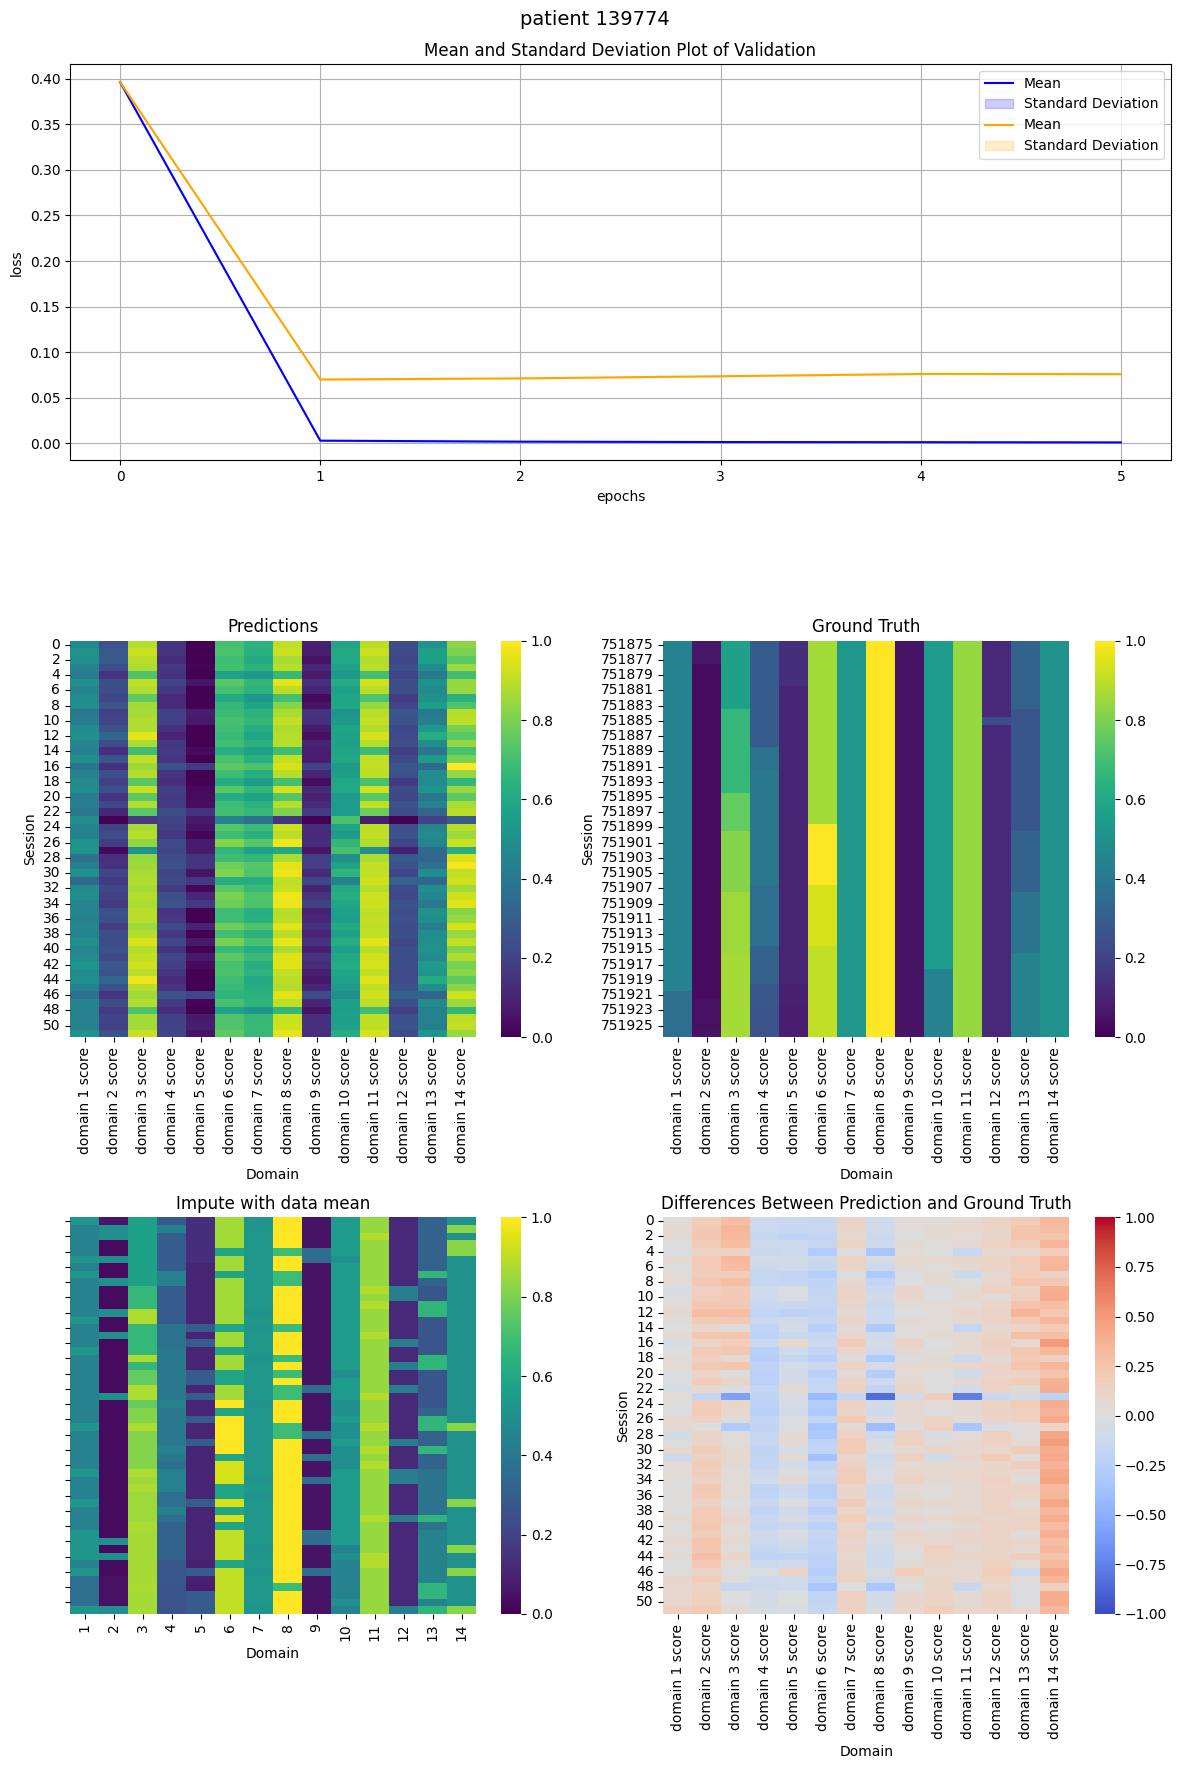

In [1499]:
# Create a figure for subplots
fig = plt.figure(figsize=(12, 18))  # Increase figure size if necessary

# set vmin and vmax
vmin = 0
vmax = 1

with torch.no_grad():
    plt.subplot(3, 1, 1)
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

# Plotting the first matrix heatmap
plt.subplot(3, 2, 3)
sns.heatmap(patient_predictions, cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("Predictions")
plt.xlabel("Domain")
plt.ylabel("Session")

# Plotting the second matrix heatmap
plt.subplot(3, 2, 4)
sns.heatmap(GT.iloc[:, -14:], cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("Ground Truth")
plt.xlabel("Domain")
plt.ylabel("Session")

# Plotting the third matrix heatmap
ax = plt.subplot(3, 2, 5)
# mean_data = np.mean(x_train, axis=0)[::2].reshape(1, -1) annot=True, annot_kws={"size": 8},
sns.heatmap(patient_impute_data, cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("Impute with data mean")
plt.xlabel("Domain")
ax.set_xticklabels(range(1, 15))
ax.set_yticklabels("")

# Heatmap of difference between two matrices
# Plotting the heatmap
plt.subplot(3, 2, 6)
sns.heatmap(difference, cmap="coolwarm", cbar=True, center=0, vmin=-1, vmax=1)
plt.title("Differences Between Prediction and Ground Truth")
plt.xlabel("Domain")
plt.ylabel("Session")

# Adjust the spacing between the plots and margins of the figure
fig.suptitle("patient %d" % pid, size=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

# Show the plot
plt.show()

In [1500]:
# torch.save(model.state_dict(), "model/model.pt")
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('model/model.pt')
# run.log_artifact(artifact)

In [1501]:
# wandb.unwatch()
# wandb.finish()

Bad pipe message: %s [b'\xb1T\xd6}\x90\x01]\xe8M\x05\xca\xa0\x00H[\xaf\xe8V\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00']
Bad pipe message: %s [b"\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\x